In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload

In [3]:
import lnPi
import lnPi.stability
#reload(lnPi.old)

In [4]:
def tag_phases_binary(x):
#    return np.argsort(x.argmax[0])
    if len(x) > 2:
#    if x.base.num_phases_max != 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 < 255/2, 0, 1)
    
    
#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)
    

In [6]:
import lnPi
from tqdm import tqdm_notebook as tqdm

In [669]:
import lnPi.serieswrapper
reload(lnPi.serieswrapper)

import lnPi.xlnPi_vec
reload(lnPi.xlnPi_vec)
reload(lnPi.segment)
import lnPi.stability_vec
reload(lnPi.stability_vec)


/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.xlnPi_vec.xrlnPiVec'> under name 'vgce' for type <class 'lnPi.core.MaskedlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:344: AccessorRegistrationWarning: registration of name 'wlnPi' for type <class 'lnPi.lnpicollections.CollectionPhases'> is overriding a preexisting attribute with the same name.
  return cls._register_listaccessor(names, accessor_wrapper=_CachedListAccessorWrapper, cache_list=cache_list)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.segment.wlnPi'> under name 'wlnPi' for type <class 'lnPi.lnpicollections.Phases'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)


<module 'lnPi.stability_vec' from '/Users/wpk/Documents/python/lnPi/stability_vec.py'>

In [670]:
ref = lnPi.MaskedlnPi.from_table('./nahs_asym_mix.07_07_07.r1.lnpi_o.dat', lnz=np.array([0.5, 0.5]), 
                                state_kws={'beta': 1.0, 'volume': 1.0}).pad()

phase_creator = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, tag_phases=tag_phases_binary, 
                                         merge_kws=dict(efac=0.8))

In [671]:
phase_creator_s = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, 
                                            phases_factory=lnPi.serieswrapper.CollectionlnPi.from_list,
                                            tag_phases=tag_phases_binary, 
                                            merge_kws=dict(efac=0.8))

In [9]:
from joblib import Parallel, delayed

In [509]:
def get_bin_spin(lnz2, phase_creator, from_builder):
    build_phases = phase_creator.build_phases_mu([None, lnz2])
    lnzs = np.linspace(-8, 8, 20)
    c = from_builder(lnzs, build_phases)
    t_spin = None
    t_bino = None
    
    try:
        c.spinodals(2, build_phases, inplace=True)
        c.binodals(2, build_phases, inplace=True)
        t_spin = c.spinodals.access.xgce_prop.table(['molfrac'], edge_dist_ref=ref)
        t_bino = c.binodals.access.xgce_prop.table(['molfrac'], edge_dist_ref=ref)
    except:
        pass
    return t_spin, t_bino


    
    
    

In [510]:
out = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(get_bin_spin)(lnz2, phase_creator, lnPi.CollectionPhases.from_builder) 
                                                     for lnz2 in tqdm(np.arange(-5, 5, 0.2)))

In [511]:
spin = xr.concat([s for s, b in out if s is not None], 'sample')
bino = xr.concat([b for s, b in out if b is not None], 'sample')

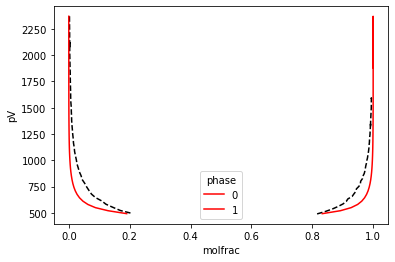

In [512]:
def plot_frame(df, **kws):
    (
        df
        .reset_index()
        .set_index(['molfrac','phase'])
        .assign(pV=lambda x: x['betapV'] / x['beta'])
        ['pV']
        .to_xarray()
        .plot(hue='phase', **kws)
    )

plot_frame(spin.to_dataframe().query('component==0 and rec==phase'), ls='--', color='k')
plot_frame(bino.to_dataframe().query('component==0'), color='r')

In [ ]:
lnPi.serieswrapper.CollectionlnPi.from_builder()

In [693]:
def get_bin_spin1(lnz2, phase_creator, from_builder, from_builder_kws=None):
    build_phases = phase_creator.build_phases_mu([None, lnz2])
    lnzs = np.linspace(-8, 8, 20)
    if from_builder_kws is None:
        from_builder_kws = {}
    c = from_builder(lnzs, build_phases, **from_builder_kws)
    t_spin = None
    t_bino = None
    
    try:
        c.spinodal(2, build_phases, inplace=True, unstack=False)
        c.binodal(2, build_phases, inplace=True, unstack=False)
        t_spin = c.spinodal.access.xgce.table(['molfrac'], ref=ref)
        t_bino = c.binodal.access.xgce.table(['molfrac'], ref=ref)
    except:
        pass
    return t_spin, t_bino


In [697]:
out1 = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(get_bin_spin1)(lnz2, phase_creator_s, lnPi.serieswrapper.CollectionlnPi.from_builder) 
                                                     for lnz2 in tqdm(np.arange(-5, 5, 0.2)))

In [698]:
spin1 = xr.concat([s for s, b in out1 if s is not None], 'sample')
bino1 = xr.concat([b for s, b in out1 if b is not None], 'sample')

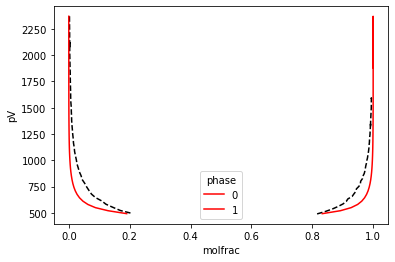

In [735]:
def plot_frame(df, **kws):
    (
        df
        .reset_index()
        .set_index(['molfrac','phase'])
        .assign(pV=lambda x: x['betapV'] / x['beta'])
        ['pV']
        .to_xarray()
        .plot(hue='phase', **kws)
    )

plot_frame(spin1.reset_index('sample').to_dataframe().query('component==0 and spinodal==phase').dropna(), ls='--', color='k')
plot_frame(bino1.reset_index('sample').to_dataframe().query('component==0').dropna(), color='r')

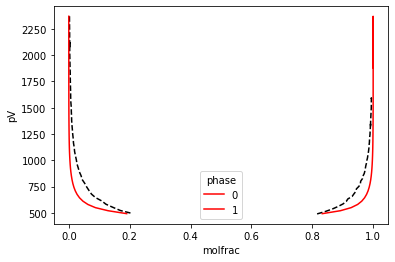

In [571]:
def plot_frame(df, **kws):
    (
        df
        .reset_index()
        .set_index(['molfrac','phase'])
        .assign(pV=lambda x: x['betapV'] / x['beta'])
        ['pV']
        .to_xarray()
        .plot(hue='phase', **kws)
    )

plot_frame(spin1.to_dataframe().query('component==0 and spinodal==phase').dropna(), ls='--', color='k')
plot_frame(bino1.to_dataframe().query('component==0').dropna(), color='r')